# Computing and visulatizing the most important words in online news

This example shows that functions can hide a lot of complexity.
* E.g., we can download remote data by just invoking a function
* In particular, in this example we will use the online service [NewsAPI](https://newsapi.org/)
  * Which allows us to download recent online news

This document has been __created by Daniele Licari__ and elaborated by Andrea Vandin.

## The modules we need to use

In [1]:
#import sys
#!{sys.executable} -m pip install newsapi-python
#!{sys.executable} -m pip install wordcloud

In [2]:
# integrating News API into your Python application 
from newsapi import NewsApiClient 
newsapi = NewsApiClient(api_key='345f8a0aa8c64d549fde1d8343d036f8')

# creating wordclouds into your Python application 
from wordcloud import WordCloud, STOPWORDS

# regular expression 
import re

import matplotlib.pyplot as plt

__NewsApiClient__ is a local client for the online service [__NewsAPI__](https://newsapi.org/) that allows you to get news from [eveywhere in the world](https://newsapi.org/sources)
* Intuitively, an online service is like an online function running in a remote server
* A local client is a piece of code runnning in your machine that communicates with the online service
  * It allows you to easily interact with the online service
  * The interaction is typically done through a set of message exchanges as prescribed by the APIs of the service
* The argument `api_key` is a univoque identifier 
  * necessary when making requests to be identified
  * can be obtained registering [here](https://newsapi.org/register)
  
There exist many online services accessible with Python
* Most of them follows this api-key approach
* E.g. to enforce subscriptions
* In our case, __we are using a free subscription that allows us to only get the first 250 characters from a news item__

## Implementing two functions for data cleaning

__Stop words__ are usually the most common in any text ( like “the”, “of”, “to” and “and”), 
* They don’t tell us much about the actual content in a text
* These are the words we want to ignore - this is our data cleaning

We want to find the words that will help us differentiate a text from texts that are about different subjects. 
* __We will filter out the common (function) words__. Words that are ignored like this are known as stop words.  
* Of course, we are going to use a function for doing this

Furthermore, we want to ignore punctuations 
* A __regular expression__ is string able to represent many other strings that _match it_
* We are going to use it to delete all punctuations from a string

In [3]:
# to remove STOPWORDS
def removeStopwords(wordlist):
    return [w for w in wordlist if (w not in STOPWORDS) and (w not in {'usa','today','verge','bbc','cnn'})]

# to remove Punctuations
def removePunctuations(txt):
    return re.sub(r'[^\w\s]','',txt)  # all non-alphanumerics are replaced with a blank space using re.

## Data loading

We first get the most relevant articles (top 50) about coronavirus, published in usa-today
* This looks like a normal function invokation
* But under the hood a lot happens to contact the remote service

Luckily, the function `get_everything` hides this complexity to us

In [4]:
json_data = newsapi.get_everything(q='coronavirus',        # All the articles that contain this word
                                    language='en',
                                    sources = 'usa-today', # The newspaper of interest
                                    #sources = 'cnn', # The newspaper of interest
                                    #sources = 'bbc-news', # The newspaper of interest
                                    #sources = 'bbc-news,the-verge'
                                    #
                                    page_size=50,           # Get 50 articles
                                    sort_by='relevancy' 
                                    )
#There exist many more parameters allowing us the ask for more articles, different sources, etc

The return value `json_data` is just a dictionary collecting information about the remote request

In [5]:
print(type(json_data))
print()
print(json_data.keys())
print()
print('The status of the request is',json_data['status'],'There are ',json_data['totalResults'],'articles matching the request.')
print('We got',len(json_data['articles']),'article')
print()

<class 'dict'>

dict_keys(['status', 'totalResults', 'articles'])

The status of the request is ok There are  2608 articles matching the request.
We got 50 article



We can ignore all the metadata (i.e. the data about the remote request) and focus on the actual articles only

In [6]:
articles = json_data['articles'] 

#Get the content of the first article
content = articles[0]['content']
print(content)
print(len(content))


White House has confirmed a second coronavirus case among West Wing staff, this time in VP Mike Pence's office. President Trump addresses concerns.
USA TODAY
Top federal health officials will testi… [+12755 chars]
215


The unformatted content of the article is truncated to 260 chars for Developer plan users

In [7]:
# now let's combine the content of all the news into 'contents' variable
def combine_articles(list_of_articles):
    contents = ''
    for article in list_of_articles:
         #  check if key 'content' has Non-None value in dictionary 
        if article['content']:
            #contents += article['content']+" "
            contents += re.split('\w+…|…', article['content'])[0]+" " # using  re.split to remove the truncated word e.g. testi… [+12755 chars]
    return contents

contents = combine_articles(articles)
print(len(contents))

8474


## Data cleaning, manipulation and visualization 

Now begins the funny part
1. Let's clean the data removing not interesting words
2. Let's compute the frequency of use of words
3. Let's visualize graphically the computed analysis - Word Cloud

In [8]:
# 1 cleaning data
def clean_data(contents):
    print('Before cleaning')
    print(contents[0:600])
    print()

    content_to_clean = contents.lower()
    clean_content = removePunctuations(content_to_clean).split()
    clean_content = removeStopwords(clean_content)
    print('After cleaning')
    print(clean_content[0:200])
    print()
    return clean_content

clean_content = clean_data(contents)

Before cleaning
White House has confirmed a second coronavirus case among West Wing staff, this time in VP Mike Pence's office. President Trump addresses concerns.
USA TODAY
Top federal health officials will  Small business owners share their difficult and confusing journeys in applying for the Paycheck Protection Program loan.
USA TODAY
Small businesses trying to get their state legislatures to force  Certain CVS Pharmacy stores will begin offering coronavirus testing in their parking lots and drive-through pharmacy lanes.
CVS Health announced Monday that starting in May, it "will offer self- The CDC re

After cleaning
['white', 'house', 'confirmed', 'second', 'coronavirus', 'case', 'among', 'west', 'wing', 'staff', 'time', 'vp', 'mike', 'pences', 'office', 'president', 'trump', 'addresses', 'concerns', 'top', 'federal', 'health', 'officials', 'will', 'small', 'business', 'owners', 'share', 'difficult', 'confusing', 'journeys', 'applying', 'paycheck', 'protection', 'program', 'loan', 

In [9]:
# 2 computing word-frequency pairs
def analyze_data(clean_content):
    wordcount = {}
    for w in clean_content:
        if w in wordcount:
            wordcount[w] += 1
        else:
            wordcount[w] = 1
    return wordcount

wordcount = analyze_data(clean_content)

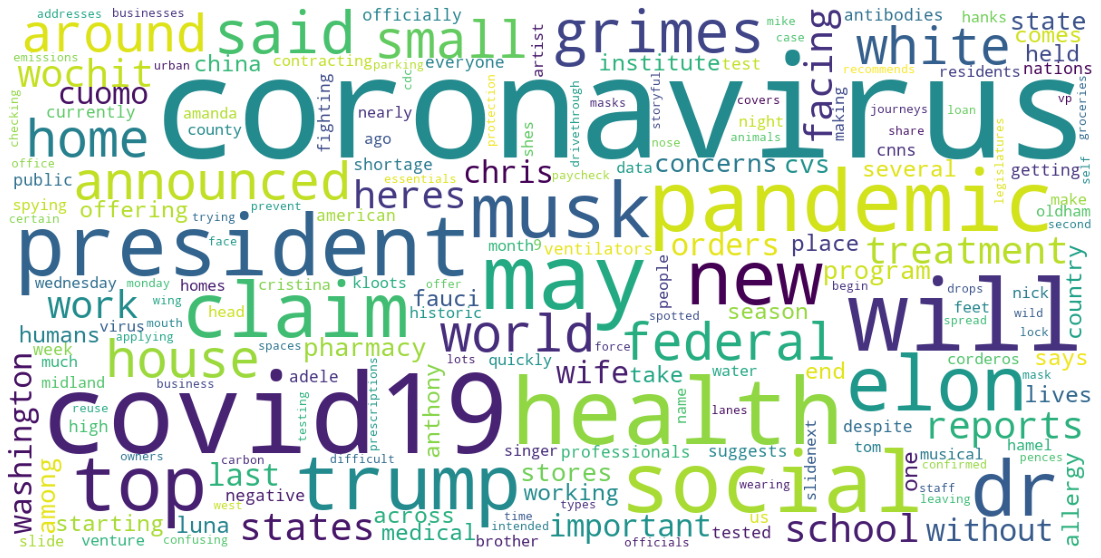

In [10]:
# 3 visualizing the analysisis in a Word Cloud
def visualize_data(wordcount):
    wc = WordCloud(width=1200,height=600, background_color='white').generate_from_frequencies(wordcount)
    plt.figure(figsize=(20,10))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

visualize_data(wordcount)

## Let's put everything in a function, so that we can run it easily for different sources

In [11]:
#import sys
#!{sys.executable} -m pip install newsapi-python
#!{sys.executable} -m pip install wordcloud

# integrating News API into your Python application 
from newsapi import NewsApiClient 
newsapi = NewsApiClient(api_key='345f8a0aa8c64d549fde1d8343d036f8')

# creating wordclouds into your Python application 
from wordcloud import WordCloud, STOPWORDS

# regular expression 
import re

import matplotlib.pyplot as plt

def make_world_cloud(query,sour,p_size):
    json_data = newsapi.get_everything(q=query,           # All the articles that contain this word
                                       language='en',
                                       sources=sour,      # The newspaper of interest
                                       page_size=p_size,  # Get 50 articles
                                       sort_by='relevancy'   
                                    )
    
    #Combine the articles in one data
    contents = combine_articles(json_data['articles'])
    
    # 1 cleaning data
    clean_content = clean_data(contents)

    # 2 computing word-frequency pairs
    wordcount = analyze_data(clean_content)
 
    # 3 visualizing the analysisis in a Word Cloud
    visualize_data(wordcount)

Before cleaning
Tesla is reopening its California car factory against Alameda Countys wishes
Tesla CEO Elon Musk has confirmed that hes reopening his companys car factory in California in violation of a local  Carnegie Robotics retrofitted the airports floor-scrubbing robots with UV lights
A UV scrubber at Pittsburgh International Airport.
Photo: Pittsburgh International Airport
Pittsburgh  Even as it beat its revenue expectations in Q2
Illustration by Alex Castro / The Verge
Qualcomm expects smartphone shipments to fall 30 percent in the comings months due to the coronavirus  Demands include better cle

After cleaning
['tesla', 'reopening', 'california', 'car', 'factory', 'alameda', 'countys', 'wishes', 'tesla', 'ceo', 'elon', 'musk', 'confirmed', 'hes', 'reopening', 'companys', 'car', 'factory', 'california', 'violation', 'local', 'carnegie', 'robotics', 'retrofitted', 'airports', 'floorscrubbing', 'robots', 'uv', 'lights', 'uv', 'scrubber', 'pittsburgh', 'international', 'airport', 

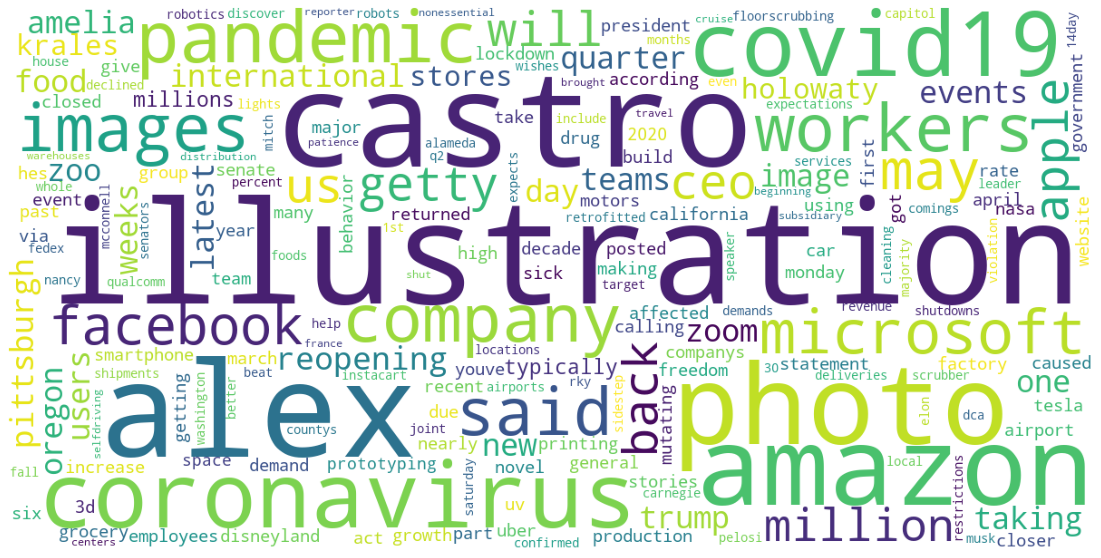

In [12]:
make_world_cloud('coronavirus','the-verge',50)

Before cleaning
Image copyrightAFP
World Health Organization (WHO) member states have agreed to set up an independent inquiry into the global response to the coronavirus pandemic. 
The resolution, approved  Image copyrightWe Are Covert
Researchers in the US and UK have identified hundreds of mutations to the virus which causes the disease Covid-19. 
But none has yet established what this will mean  Media captionMichigan protestors decry Covid-19 state of emergency
Gun-toting protesters against Michigan's coronavirus lockdown have rallied in the state capitol building.
Hundreds of  Image copyrightAFPImag

After cleaning
['image', 'copyrightafp', 'world', 'health', 'organization', 'member', 'states', 'agreed', 'set', 'independent', 'inquiry', 'global', 'response', 'coronavirus', 'pandemic', 'resolution', 'approved', 'image', 'copyrightwe', 'covert', 'researchers', 'us', 'uk', 'identified', 'hundreds', 'mutations', 'virus', 'causes', 'disease', 'covid19', 'none', 'yet', 'established', 'wi

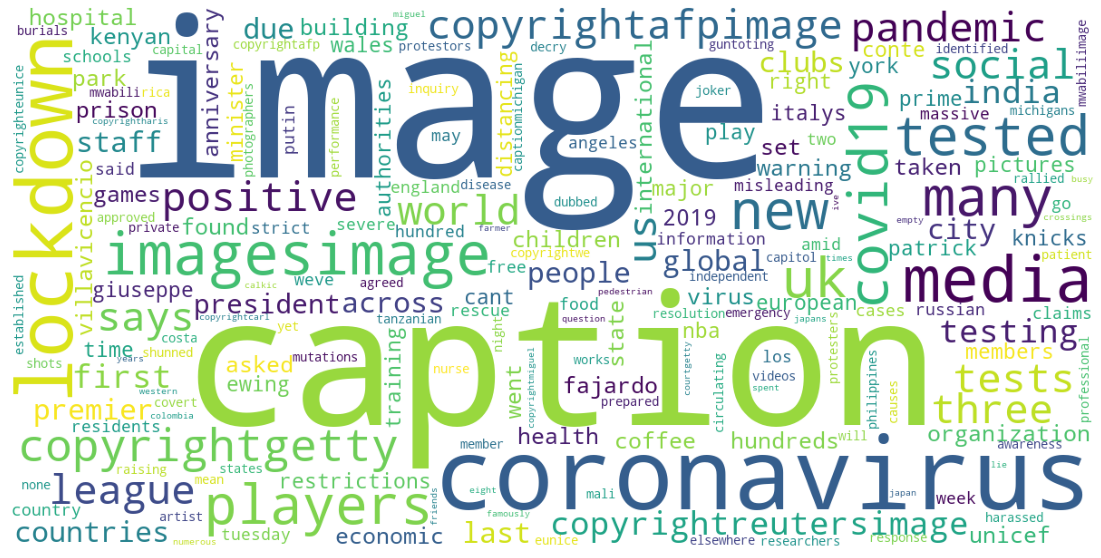

In [13]:
make_world_cloud('coronavirus','bbc-news',50)